# Imports

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

/Users/jacques/opt/anaconda3/envs/mwaa_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Germany Electricity Demand Forecast
- Basic initial prophet model
- Still to maybe add regressors like Temprature from ERA5 maybe weighted by population density and big industry.

In [2]:
df_2020 = pd.read_csv('de/de_demand_2020.csv') # Train
df_2021 = pd.read_csv('de/de_demand_2021.csv') # Train
df_2022 = pd.read_csv('de/de_demand_2022.csv') # Train
df_2023 = pd.read_csv('de/de_demand_2023.csv') # Test
df_2023 = df_2023.rename(columns={'Time (CET/CEST)': 'ds', 
                        'Day-ahead Total Load Forecast [MW] - Germany (DE)': 'dk_forecast',
                        "Actual Total Load [MW] - Germany (DE)": "y"})
df_2023

,ds,dk_forecast,y
0,01.01.2023 00:00 - 01.01.2023 00:15,42609,38883
1,01.01.2023 00:15 - 01.01.2023 00:30,42152,38565
2,01.01.2023 00:30 - 01.01.2023 00:45,41520,38438
3,01.01.2023 00:45 - 01.01.2023 01:00,40889,38260
4,01.01.2023 01:00 - 01.01.2023 01:15,40431,37894
...,...,...,...
35039,31.12.2023 22:45 - 31.12.2023 23:00,-,-
35040,31.12.2023 23:00 - 31.12.2023 23:15,-,-
35041,31.12.2023 23:15 - 31.12.2023 23:30,-,-
35042,31.12.2023 23:30 - 31.12.2023 23:45,-,-


In [3]:
df_2023['ds'] = df_2023['ds'].str.split(' - ').str[0]
df_2023['ds'] = pd.to_datetime(df_2023['ds'], format='%d.%m.%Y %H:%M')
# remote df_2023['dk_forecast'] "-" string values with 0 and make it float
df_2023['dk_forecast'] = df_2023['dk_forecast'].replace('-', 0)
df_2023['dk_forecast'] = df_2023['dk_forecast'].astype(float)
df_2023['y'] = df_2023['y'].replace('-', 0)
df_2023['y'] = df_2023['y'].astype(float)

In [4]:
# combine all dataframes
df = pd.concat([df_2020, df_2021, df_2022])
df = df.rename(columns={'Time (CET/CEST)': 'ds', 
                        'Day-ahead Total Load Forecast [MW] - Germany (DE)': 'dk_forecast',
                        "Actual Total Load [MW] - Germany (DE)": "y"})
df['ds'] = df['ds'].str.split(' - ').str[0]
df['ds'] = pd.to_datetime(df['ds'],format='%d.%m.%Y %H:%M')

In [5]:
#model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model = Prophet()
# Add a temperature regressor
#model.add_regressor('temp')
model.fit(df, algorithm='LBFGS')

14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing


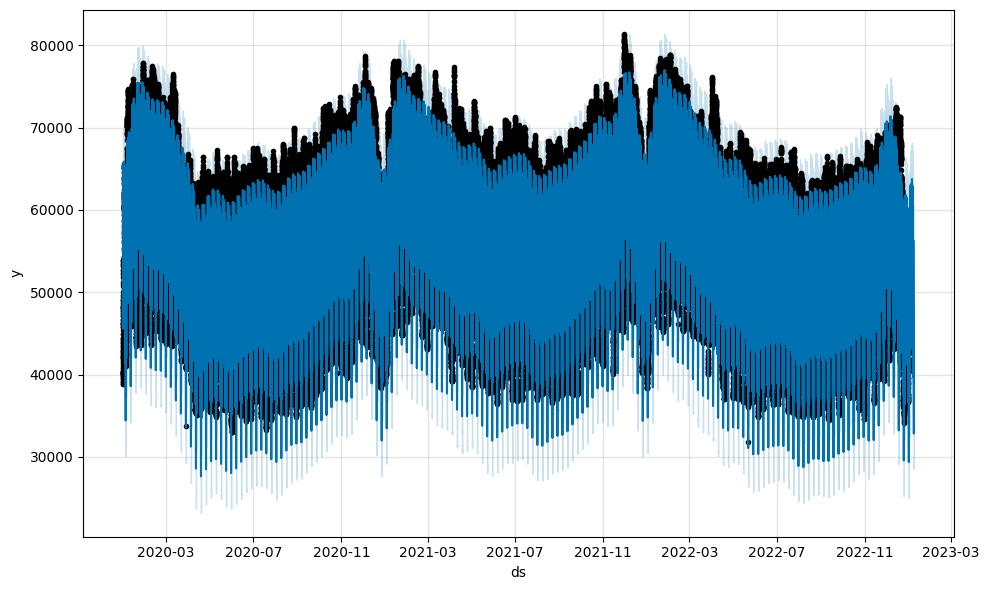

In [6]:
future = model.make_future_dataframe(periods=700,freq='15T') # 7 days of 15 min intervals in jan 2023
# Create a DataFrame with future time stamps and temperature values
# future_df = pd.DataFrame({
#     'ds': pd.date_range(start='2023-04-29', end='2023-04-30', freq='15min'),
#     'temp': [70, 72, 75, 77, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 90, 90]
# })
# Make predictions
#predictions = model.predict(future_df)
forecast = model.predict(future)
fig = model.plot(forecast)

In [7]:
forecast = forecast[forecast['ds'] >= '2023-01-01']
df2 = df_2023.merge(forecast, on='ds')

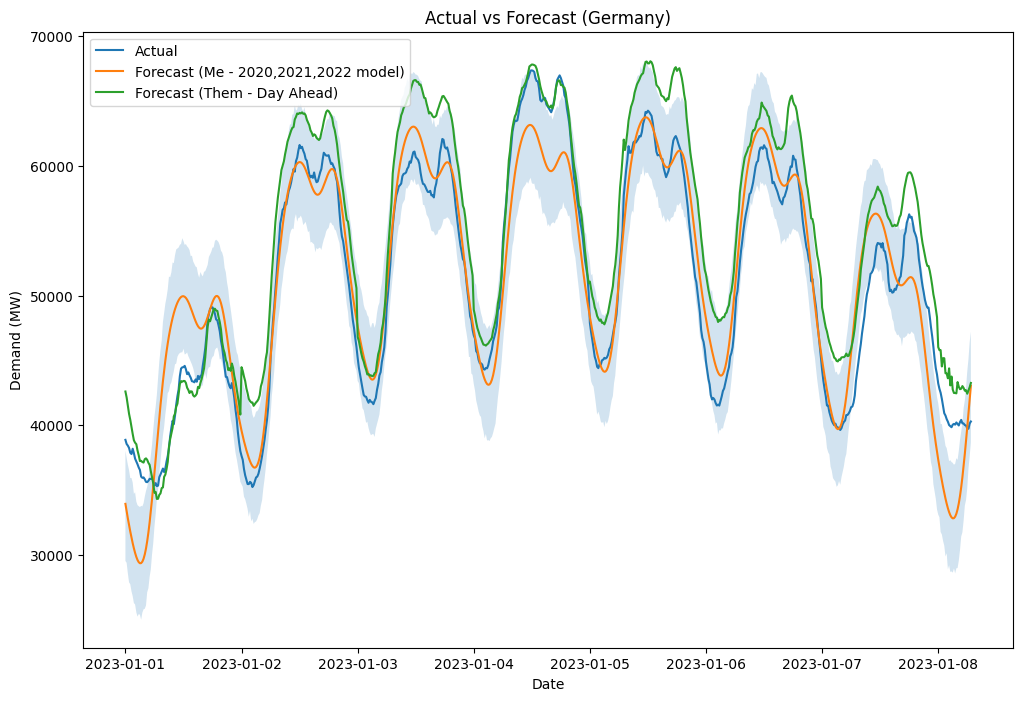

In [8]:
# plot actual vs forecast with confidence intervals on one plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df2['ds'], df2['y'], label='Actual')
ax.plot(df2['ds'], df2['yhat'], label='Forecast (Me - 2020,2021,2022 model)')
ax.plot(df2['ds'], df2['dk_forecast'], label='Forecast (Them - Day Ahead)')
ax.fill_between(df2['ds'].values, df2['yhat_lower'], df2['yhat_upper'], alpha=0.2)
ax.set_title('Actual vs Forecast (Germany)')
ax.set_xlabel('Date')
ax.set_ylabel('Demand (MW)')
ax.legend(loc='upper left')
plt.show()